# Network Intrusion Detection with Deep Learning

menggunakan stacked AE tanpa pretraining AE di hidden layer 1 dan 2, full sae MLP dengan input= 122 di seluruh layer AE

https://github.com/jay07121993/stacked-Autoencoder/blob/master/Greedy%20pre-training%20Stacked%20auto%20encoder.ipynb

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1,3" #model will be trained on GPU 0

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Open Data

In [3]:
import numpy as np
def load_matrices(file_name):
    with open(file_name, 'rb') as f:
        A = np.load(f)
        B = np.load(f)
        C = np.load(f)
        D = np.load(f)
        E = np.load(f)
        F = np.load(f)
    return (A,B,C,D,E,F)

In [4]:
my_file = '../data_NSL/data.npy'
train, test, test2, y_train, y_test, y_test2 = load_matrices(my_file)

## The Model

In [5]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation#, Merge, Reshape, Dropout
from keras.layers.embeddings import Embedding

Using TensorFlow backend.


In [6]:
# We apply a fairly simple MLP architecture

In [1]:
from keras.callbacks import ModelCheckpoint
filepath="./logsae/weights_fullsae_d.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', save_best_only=True, mode='min')
callbacks_list = [checkpoint]
filepath2="./logsae/weights_fullsae_2d.best.hdf5"
checkpoint2 = ModelCheckpoint(filepath2, monitor='val_acc', save_best_only=True, mode='max')
callbacks_list2 = [checkpoint2]


Using TensorFlow backend.


In [8]:
# We use early stopping on a holdout validation set

In [9]:
#from keras.layers.advanced_activations import ELU
from keras.activations import elu


def selu(x):
    """Scaled Exponential Linear Unit. (Klambauer et al., 2017)
    # Arguments
        x: A tensor or variable to compute the activation function for.
    # References
        - [Self-Normalizing Neural Networks](https://arxiv.org/abs/1706.02515)
    """
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    return scale * elu(x, alpha)

#model.add(Dense(32, input_shape=(input_length - 1,)), activation=selu)

In [10]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from time import time
from keras.activations import relu, elu
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam

In [11]:
# layer 1
input_dim = train.shape[1]
input_ly_1= Input(shape=(input_dim,))
enc_ly_1= Dense(100, activation= 'relu', kernel_initializer='he_uniform')(input_ly_1)
dec_ly_1=Dense(input_dim, activation='sigmoid', kernel_initializer='he_uniform')(enc_ly_1)

auto_ly_1= Model(input_ly_1, dec_ly_1)
encoder_ly_1= Model(input_ly_1, enc_ly_1)
auto_ly_1.summary()


t0 = time()
auto_ly_1.compile(loss='mse',optimizer='adam', metrics=['accuracy']) # reporting the loss

auto_ly_1.fit(train,train,
      epochs=50,
      batch_size=256,
      shuffle=True,
      callbacks=callbacks_list,                    
      #callbacks=[early_stopping])
      validation_data=(test,test))
      #validation_split=0.2)   
  
tt = time()-t0
print ("FEATURE EXTRACTION in {} seconds".format(round(tt,3)))
# if you want an encoded flatten representation of every test MNIST


ly1_predict= encoder_ly_1.predict(train)
print(ly1_predict.shape)


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 122)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 122)               12322     
Total params: 24,622
Trainable params: 24,622
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 125973 samples, validate on 22544 samples
Epoch 1/50
125973/125973 [==============================] - 2s 16us/step - loss: 0.0231 - acc: 0.1835 - val_loss: 0.0051 - val_acc: 0.1759
Epoch 2/50
125973/125973 [==============================] - 2s 13us/step - loss: 0.0026 - ac

In [12]:
# layer 2
input_ly_2= Input(shape=(100,))
enc_ly_2= Dense(20, activation= 'relu', kernel_initializer='he_uniform')(input_ly_2)
dec_ly_2=Dense(100, activation='sigmoid', kernel_initializer='he_uniform')(enc_ly_2)

auto_ly_2= Model(input_ly_2, dec_ly_2)
encoder_ly_2= Model(input_ly_2, enc_ly_2)
auto_ly_2.summary()


t0 = time()
auto_ly_2.compile(loss='mse',optimizer='adam', metrics=['accuracy']) # reporting the loss

history_a=auto_ly_2.fit(ly1_predict,ly1_predict,
      epochs=50,
      batch_size=256,
      shuffle=True,
      callbacks=callbacks_list,                    
      #callbacks=[early_stopping])
      #validation_data=(test,test))
      validation_split=0.2)   
  
tt = time()-t0
print ("FEATURE EXTRACTION in {} seconds".format(round(tt,3)))
# if you want an encoded flatten representation of every test MNIST


ly2_predict= encoder_ly_2.predict(ly1_predict)
print(ly2_predict.shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_4 (Dense)              (None, 100)               2100      
Total params: 4,120
Trainable params: 4,120
Non-trainable params: 0
_________________________________________________________________
Train on 100778 samples, validate on 25195 samples
Epoch 1/100
100778/100778 [==============================] - 3s 28us/step - loss: 0.4426 - acc: 0.0198 - val_loss: 0.4080 - val_acc: 0.0021
Epoch 2/100
100778/100778 [==============================] - 2s 24us/step - loss: 0.4027 - acc: 0.0021 - val_loss: 0.4015 - val_acc: 0.0025
Epoch 3/100
100778/100778 [==============================] - 2s 22us/step

In [18]:
# define new model encoder->Dense  22 neurons with soft max for classification 

# Deep stacked auto encoder
ly_1= auto_ly_1.layers[1].get_weights()
ly_2= auto_ly_2.layers[1].get_weights()
#ly_3= auto_ly_3.layers[1].get_weights()

input_da= Input(shape=(input_dim,))
dnn_1=Dense(100, activation='relu',  kernel_initializer='he_uniform',input_shape=(input_dim,),
            name="layer1")(input_da)
dnn_2= Dense(20, activation='relu', kernel_initializer='he_uniform',name="layer2")(dnn_1)
dnn_3= Dense(5, activation='softmax',kernel_initializer='he_uniform')(dnn_2)

dnn= Model(input_da, dnn_3)
dnn.summary()

dnn.layers[1].set_weights(ly_1) # first dense layer
dnn.layers[2].set_weights(ly_2)
#dnn.layers[3].set_weights(ly_3)


t1=time()
dnn.compile(loss='categorical_crossentropy', metrics=['accuracy'],
            optimizer= Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=0.0, amsgrad=False))
history2a=dnn.fit(train, y_train,epochs=100,batch_size=256,shuffle=True,verbose=1, 
                    callbacks=callbacks_list2, 
                     # validation_split=0)
                     validation_data=(test,y_test))
tt2 = time()-t1
print ("FEATURE CLASSIFICATION in {} seconds".format(round(tt2,3)))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 122)               0         
_________________________________________________________________
layer1 (Dense)               (None, 100)               12300     
_________________________________________________________________
layer2 (Dense)               (None, 20)                2020      
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 105       
Total params: 14,425
Trainable params: 14,425
Non-trainable params: 0
_________________________________________________________________
Train on 125973 samples, validate on 22544 samples
Epoch 1/100
125973/125973 [==============================] - 2s 14us/step - loss: 0.2921 - acc: 0.9743 - val_loss: 3.4238 - val_acc: 0.7233
Epoch 2/100
125973/125973 [==============================] - 1s 11us/step - los

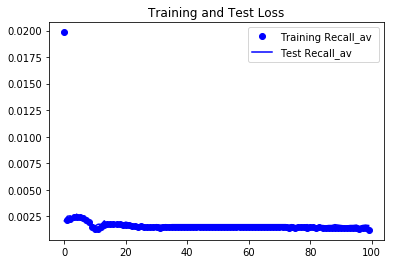

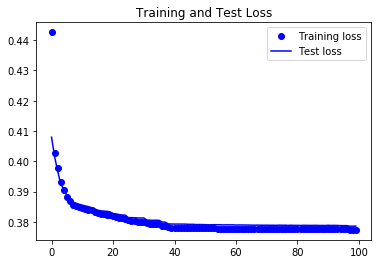

In [20]:
import matplotlib.pyplot as plt

accuracy_a = history_a.history['acc']
val_accuracy_a = history_a.history['val_acc']
loss_a = history_a.history['loss']
val_loss_a = history_a.history['val_loss']
epochs = range(len(accuracy_a))
plt.plot(epochs, accuracy_a, 'bo', label='Training Recall_av ')
plt.plot(epochs, val_accuracy_a, 'b', label='Test Recall_av')
plt.title('Training and Test Loss')
plt.legend()
plt.figure()
plt.plot(epochs, loss_a, 'bo', label='Training loss')
plt.plot(epochs, val_loss_a, 'b', label='Test loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

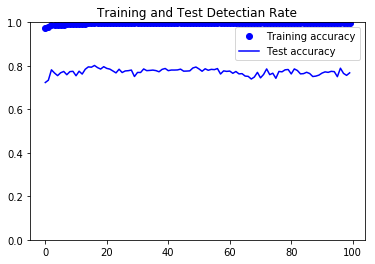

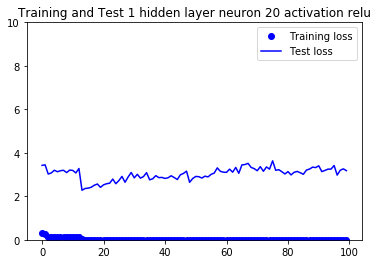

In [21]:
accuracy_2a = history2a.history['acc']
val_accuracy_2a = history2a.history['val_acc']
loss_2a = history2a.history['loss']
val_loss_2a = history2a.history['val_loss']
epochs = range(len(accuracy_2a))
plt.plot(epochs, accuracy_2a, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy_2a, 'b', label='Test accuracy')
plt.ylim(bottom=0, top=1.0)  # this line
plt.title('Training and Test Detectian Rate')
plt.legend()
plt.figure()
plt.plot(epochs, loss_2a, 'bo', label='Training loss')
plt.plot(epochs, val_loss_2a, 'b', label='Test loss')
plt.ylim(bottom=0, top=10.0)  # this line
plt.title('Training and Test 1 hidden layer neuron 20 activation relu')
plt.legend()
plt.show()

In [22]:
dnn.evaluate(test,y_test)

22544/22544 [==============================] - 0s 18us/step


[3.180602667812255, 0.7678317955997161]

In [23]:
# 4. evaluate the network
loss, val_accuracy = dnn.evaluate(train,y_train)
print("\nLoss: %.2f, Accuracy: %.2f%%" % (loss, val_accuracy*100))

125973/125973 [==============================] - 2s 18us/step

Loss: 0.00, Accuracy: 99.91%


In [18]:
# 4. evaluate the network
loss, val_accuracy = dnn.evaluate(test,y_test)
print("\nLoss: %.2f, Accuracy: %.2f%%" % (loss, val_accuracy*100))

22544/22544 [==============================] - 0s 16us/step

Loss: 3.12, Accuracy: 78.72%


## The Performance

In [24]:
from sklearn.metrics import confusion_matrix


In [ ]:
##loading autoencoder untuk data tes
# load weights
#autoencoder.load_weights("./log2/talos_weights_tes_a.best.hdf5")

# Compile model (required to make predictions)
#autoencoder.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#print("Created model and loaded weights from file")
#scores = autoencoder.evaluate(test, test, verbose=0)
#print("%s: %.2f%%" % (autoencoder.metrics_names[1], scores[1]*100))

In [25]:
##loading autoencoder untuk data tes
# load weights
dnn.load_weights(filepath2)
# Compile model (required to make predictions)
dnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Created model and loaded weights from file")
scores = dnn.evaluate(test, y_test, verbose=0)
print("%s: %.2f%%" % (dnn.metrics_names[1], scores[1]*100))

Created model and loaded weights from file
acc: 80.17%


In [26]:
scores = dnn.evaluate(test, y_test, verbose=0)
print("%s: %.2f%%" % (dnn.metrics_names[1], scores[1]*100))



acc: 80.17%


In [27]:
preds = dnn.predict(test)
pred_lbls = np.argmax(preds, axis=1)
true_lbls = np.argmax(y_test, axis=1)
# With the confusion matrix, we can aggregate model predictions
# This helps to understand the mistakes and refine the model

In [28]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [29]:
from sklearn.metrics import confusion_matrix


In [30]:
confusion_matrix(true_lbls, pred_lbls)

array([[6217, 1150,   91,    0,    0],
       [  89, 9365,  252,    0,    5],
       [ 191,  188, 2039,    3,    0],
       [   0, 2306,   10,  429,    9],
       [   0,  155,   16,    5,   24]], dtype=int64)

In [31]:
from sklearn.metrics import f1_score
f1_score(true_lbls, pred_lbls, average='weighted')

0.7727909204499254

In [32]:
# Overall, we report similar model performance to the reference above.
# Their research suggest using unsupervised pretraining with autoencoders over
# both train and test before adding classifier layers for fine-tuning.
# I have done no parameter tuning but report comparable performance.
# Note the model has diffuculty with U2R and R2L.

In [33]:
from sklearn.metrics import classification_report
outcomes = ['DoS', 'normal' ,'Probe' ,'U2R','R2L' ]
class_names=outcomes

target_names = ["Class {}".format(i) for i in range(5)]
print(classification_report(true_lbls, pred_lbls, target_names=class_names, digits=5))
#print(classification_report(Y_test, y_predict))


              precision    recall  f1-score   support

         DoS    0.95690   0.83360   0.89101      7458
      normal    0.71141   0.96437   0.81880      9711
       Probe    0.84676   0.84221   0.84448      2421
         U2R    0.98169   0.15577   0.26888      2754
         R2L    0.63158   0.12000   0.20168       200

    accuracy                        0.80172     22544
   macro avg    0.82567   0.58319   0.60497     22544
weighted avg    0.83947   0.80172   0.77279     22544



Confusion matrix, without normalization
[[6217 1150   91    0    0]
 [  89 9365  252    0    5]
 [ 191  188 2039    3    0]
 [   0 2306   10  429    9]
 [   0  155   16    5   24]]


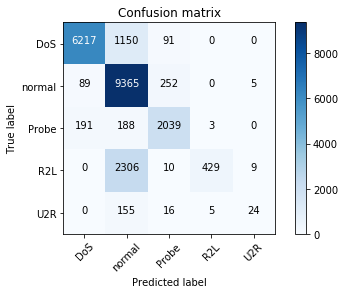

In [34]:

outcomes = ['DoS', 'normal','Probe' ,'R2L', 'U2R']
class_names=outcomes


results = confusion_matrix(true_lbls, pred_lbls)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(results, classes=class_names,
                      title='Confusion matrix')

#print(classification_report(y_test, deepprediction, target_names=class_names, digits=5))

In [ ]:
###Data Train

In [43]:
dnn.load_weights(filepath2)
# Compile model (required to make predictions)
dnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Created model and loaded weights from file")
scores = dnn.evaluate(train, y_train, verbose=0)
print("%s: %.2f%%" % (dnn.metrics_names[1], scores[1]*100))

Created model and loaded weights from file
acc: 99.82%


In [44]:
preds = dnn.predict(train)
pred_lbls = np.argmax(preds, axis=1)
true_lbls = np.argmax(y_train, axis=1)
# With the confusion matrix, we can aggregate model predictions
# This helps to understand the mistakes and refine the model

In [45]:
confusion_matrix(true_lbls, pred_lbls)

array([[45914,    13,     0,     0,     0],
       [    3, 67231,    66,    32,    11],
       [    2,    24, 11630,     0,     0],
       [    0,    64,     0,   929,     2],
       [    0,     7,     2,     0,    43]], dtype=int64)

In [46]:
from sklearn.metrics import f1_score
f1_score(true_lbls, pred_lbls, average='weighted')

0.9982030764006993

In [47]:

target_names = ["Class {}".format(i) for i in range(5)]
print(classification_report(true_lbls, pred_lbls, target_names=class_names, digits=5))
#print(classification_report(Y_test, y_predict))

              precision    recall  f1-score   support

         DoS    0.99989   0.99972   0.99980     45927
      normal    0.99840   0.99834   0.99837     67343
       Probe    0.99419   0.99777   0.99597     11656
         R2L    0.96670   0.93367   0.94990       995
         U2R    0.76786   0.82692   0.79630        52

    accuracy                        0.99821    125973
   macro avg    0.94541   0.95128   0.94807    125973
weighted avg    0.99821   0.99821   0.99820    125973



Confusion matrix, without normalization
[[45914    13     0     0     0]
 [    3 67231    66    32    11]
 [    2    24 11630     0     0]
 [    0    64     0   929     2]
 [    0     7     2     0    43]]


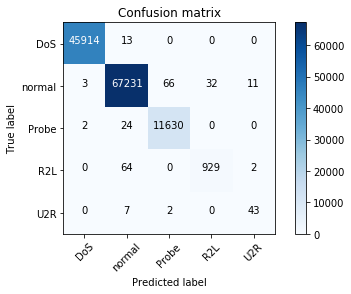

In [42]:


results = confusion_matrix(true_lbls, pred_lbls)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(results, classes=class_names,
                      title='Confusion matrix')

#print(classification_report(y_test, deepprediction, target_names=class_names, digits=5))